## Import Packages 

In [1]:
import re
import string
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from statsmodels.graphics.gofplots import qqplot


# supress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline

## Read in Data 

In [2]:
# Bring the entire data set to get the label list
clean_data = pd.read_csv('../output/clean_data.csv')
numeric_only = pd.read_csv('../output/numeric_only.csv')

# Retreive the labels for later use
label_list = clean_data['label'].unique()

label_list

array(['Name', 'Contact', 'Summary', 'Heading', 'Unknown', 'Bullet',
       'Degree', 'Certification', 'Skill', 'Title', 'Training',
       'Organization', 'Date', 'Volunteer', 'Award', 'Location',
       'Interest'], dtype=object)

In [3]:
# Sellect a target feature from the available labels to be used in analysis and training
target = 'Summary'

# Create data frames for features and labels.
features = numeric_only.drop(label_list, axis=1)
labels = numeric_only[target]

target_only_numeric = pd.concat([labels, features], axis=1)

# # Split data into training, validation, and test sets
# # - train_test_split can only split into two groups, so start with the desired training percentage,
# # - then split the remainder in half, or another fraction, to yield validation and test sets.

# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Verify Split

In [4]:
# print('Total records: {}\nTraining set:\t{}\nValidation set:\t{}\nTest set:\t{}'.format(len(labels), len(y_train), len(y_val), len(y_test)))

### Look at general distribution of the numeric features in the training set 

In [5]:
target_only_numeric.describe()

,Summary,line_length,word_count,verb_percentage,adj_percentage,stopword_percentage,punctuation_percentage,number_percentage,proper_noun_percentage
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,0.019881,67.814115,10.775348,4.668787,6.797614,2.017097,3.751690,5.096521,32.756064
std,0.139660,107.621847,17.245700,9.020396,13.240005,2.548894,8.561202,11.985355,33.091974
min,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,40.000000,6.000000,0.000000,0.000000,0.000000,2.100000,0.000000,22.200000
75%,0.000000,80.000000,13.000000,7.400000,9.100000,3.800000,4.600000,3.800000,58.300000
max,1.000000,1682.000000,281.000000,100.000000,100.000000,20.000000,100.000000,100.000000,100.000000


## Create Correlation Matrix. 
The best features have a strong correlation with the target variable only. If there is a strong correlation between other features, it can confuse the model. This must still be tested, but looking at a simple correlation matrix is helpful.

In [6]:
# Generate correlation matrix
target_only_numeric.corr()

,Summary,line_length,word_count,verb_percentage,adj_percentage,stopword_percentage,punctuation_percentage,number_percentage,proper_noun_percentage
Summary,1.000000,0.100408,0.084894,0.072684,0.025048,0.110852,-0.014176,-0.036041,-0.076780
line_length,0.100408,1.000000,0.973806,0.176698,0.012307,0.282802,0.017763,-0.096631,-0.179070
word_count,0.084894,0.973806,1.000000,0.182198,0.002600,0.315680,-0.043828,-0.072898,-0.164799
verb_percentage,0.072684,0.176698,0.182198,1.000000,-0.029493,0.319386,-0.119124,-0.128322,-0.310029
adj_percentage,0.025048,0.012307,0.002600,-0.029493,1.000000,-0.001875,-0.008183,-0.153582,-0.260959
stopword_percentage,0.110852,0.282802,0.315680,0.319386,-0.001875,1.000000,-0.148704,-0.077659,-0.411694
punctuation_percentage,-0.014176,0.017763,-0.043828,-0.119124,-0.008183,-0.148704,1.000000,0.070862,-0.087919
number_percentage,-0.036041,-0.096631,-0.072898,-0.128322,-0.153582,-0.077659,0.070862,1.000000,-0.053765
proper_noun_percentage,-0.076780,-0.179070,-0.164799,-0.310029,-0.260959,-0.411694,-0.087919,-0.053765,1.000000


## Find Feature Distributions
Given a target variable, look at the distribution of each feature for records that are and those that are not that variable.
Run a t-test on the two distributions to see if the difference is statistacally significant.

In [7]:
def describe_cont_feature(feature):
    print('\n*** Results for {}'.format(feature))
    print(target_only_numeric.groupby(target)[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    is_target = target_only_numeric[target_only_numeric[target]==1][feature]
    not_target = target_only_numeric[target_only_numeric[target]==0][feature]
    tstat, pval = stats.ttest_ind(is_target, not_target, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat,pval))

In [8]:
tr_feature_names = list(target_only_numeric.columns.values)

for feature in tr_feature_names:
    describe_cont_feature(feature)


*** Results for Summary
         count  mean  std  min  25%  50%  75%  max
Summary                                           
0        986.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1         20.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
t-statistic: inf, p-value: 0.0
None

*** Results for line_length
         count        mean         std   min   25%   50%    75%     max
Summary                                                                
0        986.0   66.275862  105.415614   3.0  19.0  40.0  77.75  1682.0
1         20.0  143.650000  174.303811  11.0  75.0  88.0  95.75   698.0
t-statistic: 2.0, p-value: 0.0624
None

*** Results for word_count
         count       mean        std  min   25%   50%   75%    max
Summary                                                           
0        986.0  10.566937  17.021637  1.0   3.0   6.0  13.0  281.0
1         20.0  21.050000  24.448603  1.0  12.0  14.0  16.0  104.0
t-statistic: 1.9, p-value: 0.0713
None

*** Results for verb_percentage
         co

## Detect Outliers

In [9]:
def detect_outlier(feature):
    outliers = []
    data = numeric_only[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean)/std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps and floors for {}:'.format(feature))
    print('   --95p: {:.1f} / {} values exceed that.'.format(data.quantile(.95),
                                                            len([i for i in data
                                                                if i > data.quantile(.95)])))
    print('   --99p: {:.1f} / {} values exceed that.'.format(data.quantile(.99),
                                                     len([i for i in data
                                                            if i > data.quantile(.99)])))
    print('   --3sd: {:.1f} / {} values exceed that.'.format(mean + 3*(std), len(outliers)))
    
for feat in features:
    detect_outlier(feat)


Outlier caps and floors for line_length:
   --95p: 215.0 / 51 values exceed that.
   --99p: 497.2 / 11 values exceed that.
   --3sd: 390.5 / 20 values exceed that.

Outlier caps and floors for word_count:
   --95p: 36.8 / 51 values exceed that.
   --99p: 79.9 / 11 values exceed that.
   --3sd: 62.5 / 18 values exceed that.

Outlier caps and floors for verb_percentage:
   --95p: 20.0 / 41 values exceed that.
   --99p: 33.3 / 10 values exceed that.
   --3sd: 31.7 / 20 values exceed that.

Outlier caps and floors for adj_percentage:
   --95p: 32.6 / 51 values exceed that.
   --99p: 50.0 / 10 values exceed that.
   --3sd: 46.5 / 25 values exceed that.

Outlier caps and floors for stopword_percentage:
   --95p: 6.5 / 51 values exceed that.
   --99p: 10.0 / 7 values exceed that.
   --3sd: 9.7 / 13 values exceed that.

Outlier caps and floors for punctuation_percentage:
   --95p: 13.0 / 50 values exceed that.
   --99p: 23.4 / 11 values exceed that.
   --3sd: 29.4 / 7 values exceed that.

Out

## Cap features
Remove all records that are more than 3  σ  from  μ, or in the 99th or 95th percentile.

In [10]:
# numeric_only['word_count'].clip(upper=35,lower=3,inplace=True)
# numeric_only.describe()

## Transform Skewed Data
####  Process
1. Determine what range of exponents to test
2. Apply each transformation to each value of your chosen feature
3. Use some criteria to determine which of the transformations yeild the best distributions

## Visually Inspect Features 

### Choose a feature to inspect

In [11]:
for feature in features.columns.values:
    print(feature)

line_length
word_count
verb_percentage
adj_percentage
stopword_percentage
punctuation_percentage
number_percentage
proper_noun_percentage


In [47]:
# Selecting a feature from the list above
feature = 'proper_noun_percentage'

#### Generate Overlapping Histograms
The orange dispersion plot is all the non-target variables, and that blue is the target variable
Stronger features will have clearly different dispersions with the two colors. The more the colors overlap, the weaker the feature at indicating the target variable.

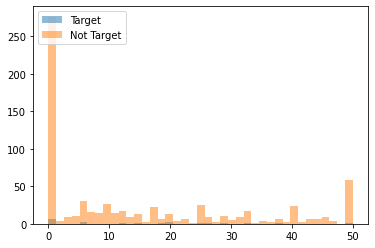

In [48]:
bins = np.linspace(0, 50, 40)

pyplot.hist(numeric_only[numeric_only[target]==1][feature], bins, alpha=0.5, label='Target')
pyplot.hist(numeric_only[numeric_only[target]==0][feature], bins, alpha=0.5, label='Not Target')
pyplot.legend(loc='upper left')
pyplot.show()

#### Generate QQ Plots
The red line represents the theoretical line that would be plotted based on this data set, if the data were perfectly linearly related. The blue dots are the actual data points from the data set, after they have undergone the transformatiion listed at the top of the plot.

The goal is to select the transformation that gets the blue dots as close to the red line as possible.

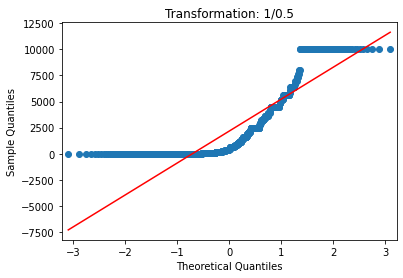

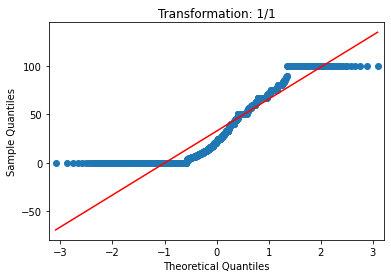

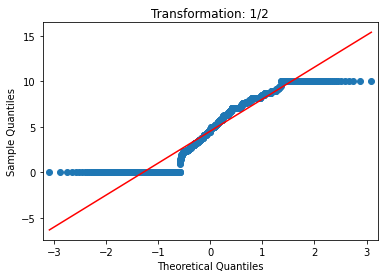

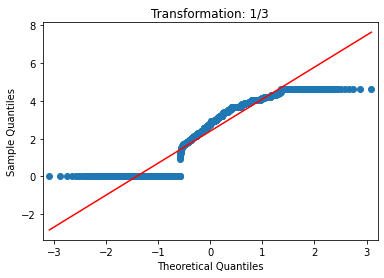

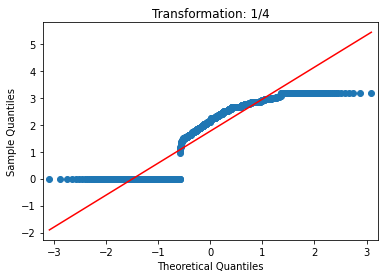

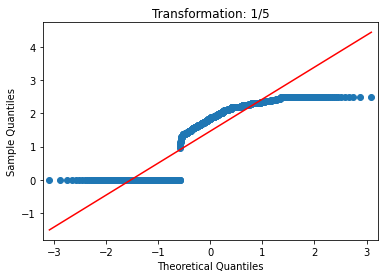

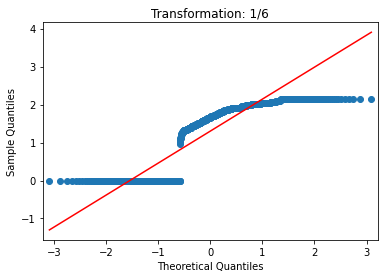

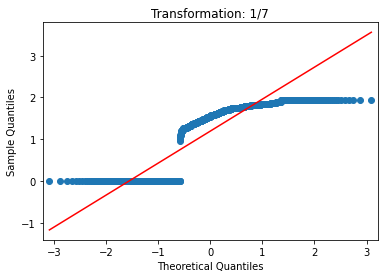

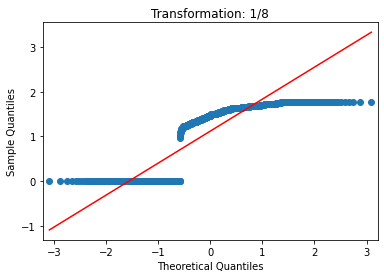

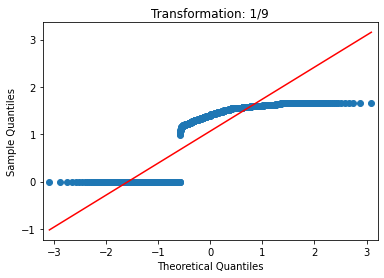

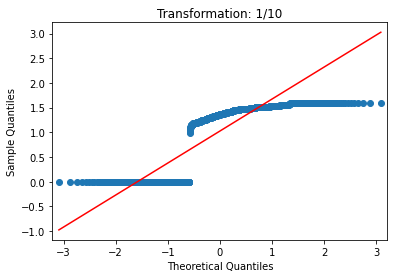

In [49]:
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = numeric_only[feature]**(1/i)
    qqplot(data_t, line='s')
    pyplot.title('Transformation: 1/{}'.format(str(i)))

#### Generate Layered Histograms
The orange line represents a perfectly normal distribution based on the actual $\mu$ and $\sigma$ of the data set.
The blue represents the actual distribution of the data set after undergoing the transformation liseted at the top of the plot.

The goal is to select the transformation that aligns the blue most closely with the orange

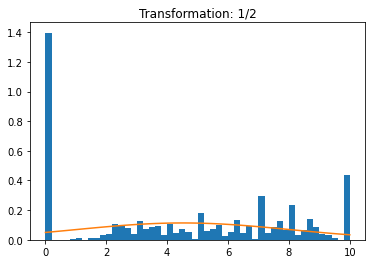

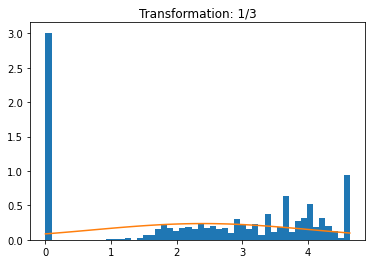

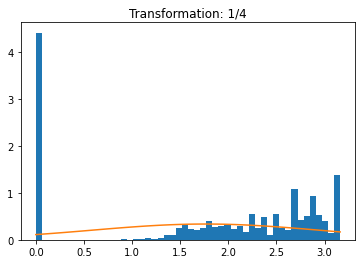

In [50]:
# Select lower (inclusive) and upper (exclusive) limits for the denominator to be multiplied in the "feature * 1/n"  
transformations = range(2, 5)

for i in transformations:
    data_t = numeric_only[feature]**(1/i)
    n, bins, pathches = pyplot.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    pyplot.plot(bins, stats.norm.pdf(bins, mu, sigma))
    pyplot.title('Transformation: 1/{}'.format(str(i)))
    pyplot.show()

#### Add Transformed Data
Based on investigation above, make any transformations necessary, and add them to separate columns of the training data.

In [51]:
numeric_only['line_length_trans'] = numeric_only['line_length'].apply(lambda x : x**(1/9))

numeric_only['word_count_trans'] = numeric_only['word_count'].apply(lambda x : x**(1/10))

numeric_only['verb_percentage_trans'] = numeric_only['verb_percentage'].apply(lambda x : x**(1/3))

numeric_only['adj_percentage_trans'] = numeric_only['adj_percentage'].apply(lambda x : x**(1/4))

numeric_only['stopword_percentage_trans'] = numeric_only['stopword_percentage'].apply(lambda x : x**(1/2))

numeric_only['punctuation_percentage_trans'] = numeric_only['punctuation_percentage'].apply(lambda x : x**(1/2))

numeric_only['number_percentage_trans'] = numeric_only['number_percentage'].apply(lambda x : x**(1/2))

numeric_only['proper_noun_percentage_trans'] = numeric_only['proper_noun_percentage'].apply(lambda x : x**(1/4))


numeric_only.head()

,line_length,word_count,verb_percentage,adj_percentage,stopword_percentage,punctuation_percentage,number_percentage,proper_noun_percentage,Award,Bullet,...,Unknown,Volunteer,line_length_trans,word_count_trans,verb_percentage_trans,adj_percentage_trans,stopword_percentage_trans,punctuation_percentage_trans,number_percentage_trans,proper_noun_percentage_trans
0,13,2,0.0,0.0,0.0,0.0,0.0,100.0,0,0,...,0,0,1.329755,1.071773,0.000000,0.000000,0.000000,0.000000,0.000000,3.162278
1,57,7,0.0,7.7,0.0,10.5,23.1,30.8,0,0,...,0,0,1.567102,1.214814,0.000000,1.665799,0.000000,3.240370,4.806246,2.355796
2,698,104,4.1,4.1,4.9,2.7,2.5,12.3,0,0,...,0,0,2.070065,1.591121,1.600521,1.422971,2.213594,1.643168,1.581139,1.872735
3,22,2,0.0,50.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1.409802,1.071773,0.000000,2.659148,0.000000,0.000000,0.000000,0.000000
4,67,9,10.0,0.0,1.5,3.0,20.0,40.0,0,0,...,1,0,1.595501,1.245731,2.154435,0.000000,1.224745,1.732051,4.472136,2.514867


## Split data into training, validation, and test sets 

In [52]:
# Create data frames for features and labels.
features = numeric_only.drop(label_list, axis=1)
labels = numeric_only[target]

# train_test_split can only split into two groups, so start with the desired training percentage,
# - then split the remainder in half, or another fraction, to yield validation and test sets.

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Verify split
print('Total records: {}\nTraining set:\t{}\nValidation set:\t{}\nTest set:\t{}'.format(len(labels), len(y_train), len(y_val), len(y_test)))

Total records: 1006
Training set:	603
Validation set:	202
Test set:	201


In [53]:
X_train.head()

,line_length,word_count,verb_percentage,adj_percentage,stopword_percentage,punctuation_percentage,number_percentage,proper_noun_percentage,line_length_trans,word_count_trans,verb_percentage_trans,adj_percentage_trans,stopword_percentage_trans,punctuation_percentage_trans,number_percentage_trans,proper_noun_percentage_trans
650,9,1,0.0,0.0,0.0,0.0,0.0,0.0,1.276518,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
448,71,15,6.2,0.0,5.6,1.4,6.2,25.0,1.605814,1.311019,1.837091,0.000000,2.366432,1.183216,2.48998,2.236068
533,5,2,0.0,0.0,20.0,0.0,0.0,66.7,1.195813,1.071773,0.000000,0.000000,4.472136,0.000000,0.00000,2.857798
622,36,4,0.0,50.0,0.0,0.0,0.0,0.0,1.489095,1.148698,0.000000,2.659148,0.000000,0.000000,0.00000,0.000000
752,15,1,0.0,100.0,0.0,6.7,0.0,0.0,1.351067,1.000000,0.000000,3.162278,0.000000,2.588436,0.00000,0.000000


In [56]:
# Define a list of features to be used for each dataset
raw_features = ['line_length', 'word_count','verb_percentage','adj_percentage','stopword_percentage','punctuation_percentage','number_percentage', 'proper_noun_percentage']

transformed_features = ['line_length_trans','word_count_trans', 'verb_percentage_trans','adj_percentage_trans','stopword_percentage_trans','punctuation_percentage_trans','number_percentage_trans','proper_noun_percentage_trans']

reduced_features = ['line_length','word_count','verb_percentage_trans','adj_percentage']

### Write out Data 

In [57]:
# All feature sets
X_train.to_csv('../output/train_features_all.csv', index=False)
X_val.to_csv('../output/val_features_all.csv', index=False) 
X_test.to_csv('../output/test_features_all.csv', index=False)

# Raw feature sets
X_train[raw_features].to_csv('../output/train_features_raw.csv',index=False)
X_val[raw_features].to_csv('../output/val_features_raw.csv',index=False)
X_test[raw_features].to_csv('../output/test_features_raw.csv',index=False)

# Transformed feature sets
X_train[transformed_features].to_csv('../output/train_features_trans.csv',index=False)
X_val[transformed_features].to_csv('../output/val_features_trans.csv',index=False)
X_test[transformed_features].to_csv('../output/test_features_trans.csv',index=False)

# Reduced feature sets
X_train[reduced_features].to_csv('../output/train_features_reduced.csv',index=False)
X_val[reduced_features].to_csv('../output/val_features_reduced.csv',index=False)
X_test[reduced_features].to_csv('../output/test_features_reduced.csv',index=False)

# Labels
y_train.to_csv('../output/train_labels.csv', index=False)
y_val.to_csv('../output/val_labels.csv', index=False) 
y_test.to_csv('../output/test_labels.csv', index=False)